# Idalia

## imports

importing stuff

In [160]:
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import interpolate
from microSWIFTtelemetry import pull_telemetry_as_var
import pickle



#test



from typing import Optional, Union, Sequence
from matplotlib.axes import Axes
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



default_hurricane_offset_image_kwargs = {
    'zoom': 0.06,
}
def plot_hurricane_symbol(
    ax,
    image_path='./images/hurricane.png',
    xy=(0, 0),
    offset_image_kwargs: Optional[dict] = None,
    annotation_bbox_kwargs: Optional[dict] = None,
) -> None:
    offset_image_kwargs = _set_kwarg_defaults(
        default_hurricane_offset_image_kwargs,
        offset_image_kwargs,
    )
    image = plt.imread(image_path)
    plot_image(
        ax,
        image,
        xy,
        offset_image_kwargs=offset_image_kwargs,
        annotation_bbox_kwargs=annotation_bbox_kwargs,
    )

#

# Image plotting
default_annotation_bbox_kwargs = {
    'xycoords': 'data',
    'frameon': False,
    'clip_on': True,
}
default_offset_image_kwargs = {
    'zoom': 1,
}

def plot_image(
    ax: Axes,
    image: np.ndarray,
    xy: Sequence[float],
    offset_image_kwargs: Optional[dict] = None,
    annotation_bbox_kwargs: Optional[dict] = None,
) -> None:
    annotation_bbox_kwargs = _set_kwarg_defaults(
        default_annotation_bbox_kwargs,
        annotation_bbox_kwargs,
    )
    offset_image_kwargs = _set_kwarg_defaults(
        default_offset_image_kwargs,
        offset_image_kwargs,
    )
    imagebox = OffsetImage(image, **offset_image_kwargs)
    imagebox.image.axes = ax  #TODO: check if this is necessary
    annotation = AnnotationBbox(
        imagebox,
        xy=xy,
        **annotation_bbox_kwargs,
    )
    ax.add_artist(annotation)


def _set_kwarg_defaults(
    default_kwargs: dict,
    kwargs: Optional[dict] = None,
) -> dict:
    if kwargs is None:
        kwargs = default_kwargs
    else:
        for key in default_kwargs.keys():
            if key not in kwargs:
                kwargs[key] = default_kwargs[key]
    return kwargs

    # cylic legend
legend_location = [0.05, 0.08 ,0.2, 0.2]  # x, y, width, height
ax2 = ax.inset_axes(legend_location, projection='polar')
azimuths = np.arange(0, 361, 1)
zeniths = np.linspace(0.2, 1, 10)
values = azimuths * np.ones((len(zeniths), len(azimuths)))
ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap=cmap)
ax2.set_yticks([])
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.xaxis.grid(False)
ax2.tick_params(pad=-3,labelsize=10)
ax2.set_ylim([0, 1])
ax2.set_xticks([0, np.pi/2, np.pi])
ax2.set_xticks([0, np.pi/2])

ax2.set_xlabel('azimuth', fontsize=10, labelpad=2)
    # arrow
ax3 = ax.inset_axes(legend_location)
arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])







## getting data

In [161]:
def concatenate_drifters(drifter_dict: dict) -> pd.DataFrame:
    """
    Concatenate a dictionary of individual drifter DataFrames into a single,
    multi-index DataFrame.  Drop the observations that do not contain waves
    (remove off-hour pressure and temperature observations).

    Args:
        drifter_dict (dict): individual drifter DataFrames keyed by id.

    Returns:
        DataFrame: concatenated drifters
    """
    drifter_df = (
        pd.concat(drifter_dict, names=['id', 'time'])
        .dropna(subset='energy_density')
    )
    return drifter_df

DRIFTER_DATA_PATH = './hurricane_idalia_drifter_data_v3.pickle'

with open(DRIFTER_DATA_PATH, 'rb') as handle:
    drifter_data = pickle.load(handle)

# Concatenate the indivudal drifter DataFrames by type
microswift_df = concatenate_drifters(drifter_data['microswift'])
dwsd_df = concatenate_drifters(drifter_data['dwsd'])
spotter_df = concatenate_drifters(drifter_data['spotter'])

# Create a drifter type column
microswift_df['drifter_type'] = 'microswift'
dwsd_df['drifter_type'] = 'dwsd'
spotter_df['drifter_type'] = 'spotter'

# Combine all drifters into a single DataFrame.
drifter_df = (pd.concat([microswift_df, dwsd_df, spotter_df])
              .sort_index(level=['id', 'time'], ascending=True))

### data points at given times 

In [162]:
#drifterids = drifter_df.index.get_level_values(level="id").unique()
# Data summary:
#microswift_df.info()
# Get the data
start_date = pd.Timestamp('2023-08-29 12:00Z')
end_date = pd.Timestamp('2023-08-31 00:00Z')
buoy_id = '048'
#create list of bout id numbers and loop through
microswift_df, errors_df = pull_telemetry_as_var(
    buoy_id,
    start_date=start_date,
    end_date=end_date,
    var_type='pandas',
)

# Data summary:
microswift_df.info()

IBTRACS_BASE_URL = ('https://www.ncei.noaa.gov/data/international-best-'
                    'track-archive-for-climate-stewardship-ibtracs/'
                    'v04r00/access/csv/')
IBTRACS_BASE_CSV = f'ibtracs.last3years.list.v04r00.csv'
IBTRACS_PATH = IBTRACS_BASE_URL + IBTRACS_BASE_CSV
ibtracs_df = pd.read_csv(IBTRACS_PATH, low_memory=False)
ibtracs_df = (ibtracs_df
    .query('NAME == "IDALIA"')
    .assign(ISO_TIME = lambda df: pd.to_datetime(df['ISO_TIME'], utc=True))
    .set_index('ISO_TIME', drop=True)
    .assign(LAT = lambda df: df['LAT'].astype(np.float64))
    .assign(LON = lambda df: df['LON'].astype(np.float64))
)

ibtracs_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 2023-08-29 12:35:12+00:00 to 2023-08-30 23:34:24+00:00
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   significant_height  34 non-null     float64
 1   peak_period         34 non-null     float64
 2   peak_direction      34 non-null     float64
 3   energy_density      34 non-null     object 
 4   frequency           34 non-null     object 
 5   a1                  34 non-null     object 
 6   b1                  34 non-null     object 
 7   a2                  34 non-null     object 
 8   b2                  34 non-null     object 
 9   check               34 non-null     object 
 10  u_mean              0 non-null      object 
 11  v_mean              0 non-null      object 
 12  z_mean              0 non-null      object 
 13  latitude            34 non-null     float64
 14  longitude           34 non-null     float64
 15  temperatu

In [163]:
ibtracs_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104 entries, 2023-08-26 12:00:00+00:00 to 2023-09-08 06:00:00+00:00
Columns: 162 entries, SID to STORM_DIR
dtypes: float64(2), int64(1), object(159)
memory usage: 132.4+ KB


In [164]:
drifterids = drifter_df.index.get_level_values(level="id").unique()


## plotting things

###significant wave height

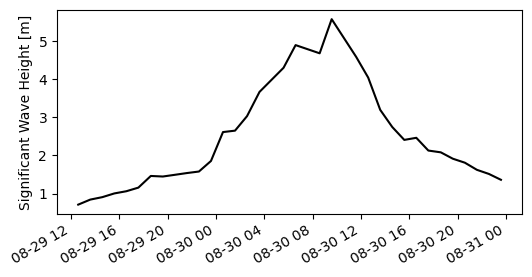

In [165]:
# Example: get the significant wave height for every microSWIFT:
microswift_df['significant_height']

# Plot the significant wave height versus time:
fig, ax = plt.subplots(figsize=(6, 3))
sc = ax.plot(
    microswift_df.index,  # this is how you access the times
    microswift_df['significant_height'],
    color='black',
)
ax.set_ylabel('Significant Wave Height [m]')
fig.autofmt_xdate()



In [166]:
### significant wave height in terms of the latitude and longitude from 1 microSWIFT

In [167]:
#cmap = 'viridis'
#norm = plt.Normalize(0, 6)  # min, max


#fig, ax = plt.subplots(figsize=(5, 5))
#sc = ax.scatter(x,y,c=c,norm=norm, cmap=cmap)
#microswift_df['longitude'],
#microswift_df['latitude'],
#c=microswift_df['significant_height'],
#cmap=cmap,
#norm=norm,
##fig.colorbar(sc, ax=ax, label='Significant Wave Height [m]')
#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')


#plt.show()


## latitude, longitude, center of hurricane

In [168]:
#getting data



peak direction, distance from center of hurricane

In [170]:


#distance=np.sqrt((LON-longitude)**2 +(LAT-latitude)**2)

interpolation experimentation 

In [171]:
microswift_df

,significant_height,peak_period,peak_direction,energy_density,frequency,a1,b1,a2,b2,check,...,z_mean,latitude,longitude,temperature,salinity,voltage,sensor_type,com_port,payload_size,time
datetime,,,,,,,,,,,,,,,,,,,,,
2023-08-29 12:35:12+00:00,0.709473,4.492188,356.500,"[0.313232421875, 0.2100830078125, 0.1529541015...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[-0.08, 0.03, -0.07, -0.12, -0.08, -0.04, 0.23...","[0.03, -0.07, 0.07, -0.09, 0.1, 0.08, 0.64, 0....","[-0.26, -0.2, -0.5, -0.26, -0.16, -0.37, -0.48...","[0.24, 0.13, 0.09, 0.12, -0.32, -0.06, 0.41, 0...","[0.4, 0.8, 0.6, 0.7, 0.9, 1.1, 0.8, 1.0, 1.0, ...",...,None,28.263271,-83.418877,0.0,0.0,6.199219,52,51,327,1.693313e+18
2023-08-29 13:34:56+00:00,0.841309,4.804688,180.500,"[0.34130859375, 0.292724609375, 0.226196289062...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[0.01, 0.07, -0.09, -0.16, -0.23, 0.0, 0.27, 0...","[0.1, 0.06, 0.23, 0.19, 0.23, 0.16, 0.66, 0.71...","[-0.23, -0.21, -0.51, -0.26, -0.21, -0.53, -0....","[0.1, -0.12, -0.11, -0.29, -0.28, 0.07, 0.41, ...","[0.5, 0.5, 0.8, 0.4, 0.7, 0.8, 0.5, 0.7, 1.1, ...",...,None,28.271105,-83.420311,0.0,0.0,6.199219,52,53,327,1.693316e+18
2023-08-29 14:34:40+00:00,0.905273,5.003906,182.875,"[0.4560546875, 0.2705078125, 0.2298583984375, ...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[-0.13, -0.07, -0.07, -0.07, -0.05, -0.23, 0.4...","[-0.12, -0.07, 0.16, 0.07, 0.31, 0.2, 0.62, 0....","[-0.52, -0.37, -0.37, -0.4, -0.34, -0.02, -0.2...","[0.1, 0.06, -0.05, -0.07, -0.03, -0.06, 0.62, ...","[1.0, 1.0, 0.8, 0.9, 1.1, 2.1, 1.0, 0.7, 1.1, ...",...,None,28.279497,-83.422104,0.0,0.0,6.199219,52,64,327,1.693320e+18
2023-08-29 15:34:24+00:00,1.002930,5.390625,187.500,"[0.40869140625, 0.2783203125, 0.1531982421875,...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[-0.26, -0.06, -0.1, 0.15, -0.07, 0.03, 0.26, ...","[0.34, 0.17, 0.22, -0.04, 0.06, 0.37, 0.59, 0....","[-0.22, -0.48, -0.22, -0.18, -0.16, -0.31, -0....","[-0.29, -0.33, -0.39, -0.22, 0.04, -0.2, 0.36,...","[0.7, 1.2, 1.3, 1.5, 0.7, 1.1, 0.6, 0.8, 0.7, ...",...,None,28.287418,-83.425354,0.0,0.0,6.199219,52,66,327,1.693323e+18
2023-08-29 16:34:08+00:00,1.060547,5.753906,193.250,"[0.517578125, 0.3046875, 0.224365234375, 0.195...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[-0.05, 0.01, 0.09, -0.01, 0.04, -0.01, -0.14,...","[-0.16, -0.05, -0.02, 0.19, 0.16, 0.13, 0.15, ...","[-0.43, -0.23, -0.34, -0.44, -0.44, -0.6, -0.4...","[-0.19, -0.28, 0.09, -0.02, 0.16, -0.13, 0.12,...","[0.8, 0.8, 0.6, 1.0, 1.0, 1.1, 0.8, 0.6, 0.9, ...",...,None,28.294340,-83.431091,0.0,0.0,6.199219,52,62,327,1.693327e+18
2023-08-29 17:33:52+00:00,1.155273,6.644531,191.250,"[0.422607421875, 0.281494140625, 0.32788085937...","[0.009765625, 0.021490329649390245, 0.03321503...","[0.04, 0.12, -0.15, 0.08, -0.07, 0.1, 0.11, 0....","[0.27, 0.18, 0.29, 0.17, 0.15, 0.45, 0.26, 0.6...","[-0.25, -0.43, -0.44, -0.23, -0.13, -0.51, -0....","[0.11, 0.11, -0.06, 0.19, -0.18, 0.32, 0.42, 0...","[0.7, 0.9, 0.7, 0.9, 0.8, 1.3, 0.6, 0.7, 0.7, ...",...,None,28.300833,-83.439331,0.0,0.0,6.199219,52,64,327,1.693330e+18
2023-08-29 18:35:44+00:00,1.460938,6.167969,192.125,"[0.8876953125, 0.57568359375, 0.51318359375, 0...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[0.0, -0.01, 0.07, 0.02, 0.07, 0.0, 0.21, 0.37...","[0.01, 0.05, 0.12, 0.06, -0.13, 0.22, 0.34, 0....","[-0.58, -0.34, -0.43, -0.45, -0.3, -0.37, -0.4...","[-0.18, -0.31, 0.23, 0.09, -0.18, 0.12, 0.51, ...","[0.4, 0.8, 0.9, 1.0, 0.8, 0.8, 0.8, 1.2, 0.8, ...",...,None,28.309361,-83.449539,0.0,0.0,6.199219,52,65,327,1.693334e+18
2023-08-29 19:35:28+00:00,1.446289,6.648438,192.125,"[0.7548828125, 0.62060546875, 0.417236328125, ...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[0.03, 0.06, -0.06, 0.03, -0.03, 0.11, 0.12, 0...","[-0.19, -0.02, 0.05, 0.01, 0.1, 0.09, 0.55, 0....","[-0.2, -0.2, -0.15, -0.45, -0.42, -0.49, -0.71...","[0.14, -0.03, -0.01, -0.03, 0.09, 0.19, 0.14, ...","[1.2, 0.8, 1.1,

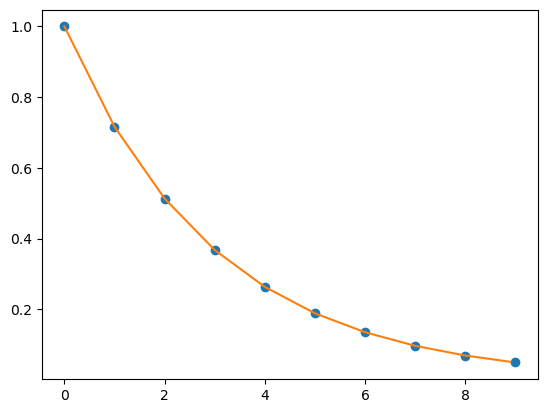

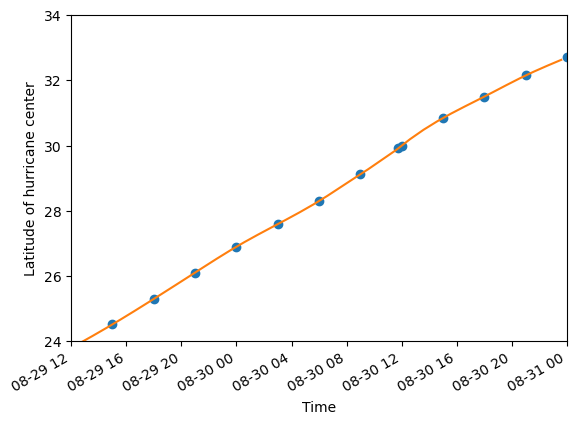

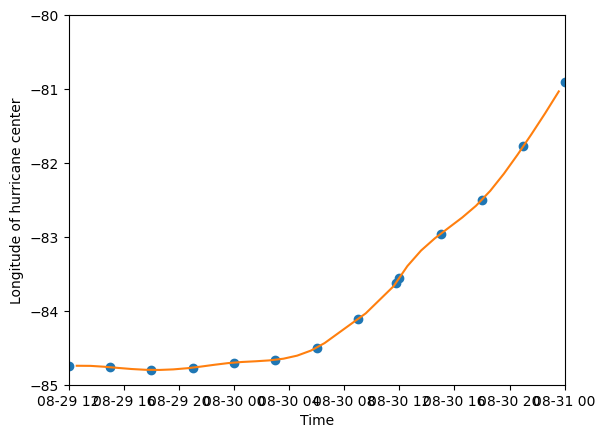

In [172]:
#x -85, -83
#y 28, 30

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)
xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

#latitude and time
x = ibtracs_df.index
y = ibtracs_df['LAT']
f = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")
latxnew = microswift_df.index #correspond to the microswift times
latynew = f(pd.to_numeric(latxnew))   # use interpolation function returned by `interp1d`

fig, ax = plt.subplots()
ax.plot(x, y, 'o', latxnew, latynew, '-')
ax.set_xlabel('Time')
ax.set_ylabel('Latitude of hurricane center')
ax.set_ylim([24, 34])
ax.set_xlim([pd.Timestamp('2023-08-29 12:00Z'), pd.Timestamp('2023-08-31 00:00Z')])
fig.autofmt_xdate()
plt.show()

#longitude and time
x = ibtracs_df.index
y = ibtracs_df['LON']
f = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")
lonxnew = microswift_df.index #correspond to the microswift times
lonynew = f(pd.to_numeric(lonxnew))   # use interpolation function returned by `interp1d`

fig, ax = plt.subplots()
ax.plot(x, y, 'o', lonxnew, lonynew, '-')
ax.set_xlabel('Time')
ax.set_ylabel('Longitude of hurricane center')
ax.set_ylim([-85, -80])
ax.set_xlim([pd.Timestamp('2023-08-29 12:00Z'), pd.Timestamp('2023-08-31 00:00Z')])
plt.show()

graphing microswift positions in relation to hurricane center

#latitudes and longitudes

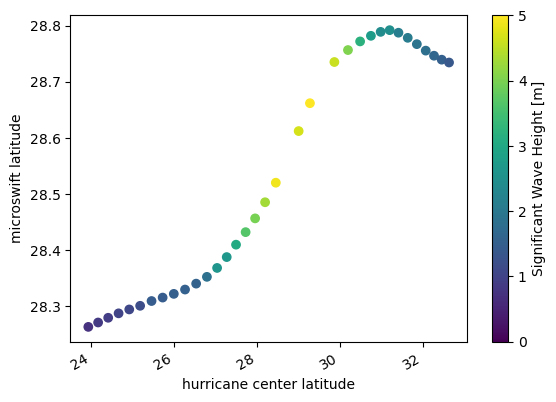

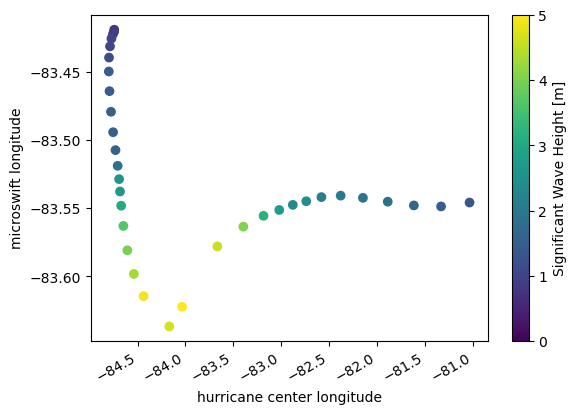

In [173]:

x = latynew
y=microswift_df['latitude']
c=microswift_df['significant_height']

cmap = 'viridis'
norm = plt.Normalize(0, 5)  # min, max

fig, ax = plt.subplots()
sc = ax.scatter(x,y,c=c,norm=norm, cmap=cmap)
ax.set_xlabel('hurricane center latitude')
ax.set_ylabel('microswift latitude')
fig.autofmt_xdate()

fig.colorbar(sc, ax=ax, label='Significant Wave Height [m]')

plt.show()


#longitude

x = lonynew
y=microswift_df['longitude']
c=microswift_df['significant_height']

cmap = 'viridis'
norm = plt.Normalize(0, 5)  # min, max

fig, ax = plt.subplots()
sc = ax.scatter(x,y,c=c,norm=norm, cmap=cmap)
ax.set_xlabel('hurricane center longitude')
ax.set_ylabel('microswift longitude')
fig.autofmt_xdate()

fig.colorbar(sc, ax=ax, label='Significant Wave Height [m]')

plt.show()


#radial distance of microSWIFT from hurricane center

jake email about converting lat and lon to coordinate plane

def great_circle_pairwise(
    longitude_a: np.ndarray,
    latitude_a: np.ndarray,
    longitude_b: np.ndarray,
    latitude_b: np.ndarray,
    earth_radius: float = 6378.137,
    mod_bearing: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the great circle distance (km) and true fore bearing (deg) between
    pairs of observations in input arrays `longitude_a` and `longitude_b` and
    `latitude_a` and `latitude_b`.

    For two longitude and latitude pairs, the great circle distance is the
    shortest distance between the two points along the Earth's surface. This
    distance is calculated using the Haversine formula. The instances in
    `longitude_a` and `latitude_a` are designated as point `a`; the instances
    in `longitude_b` and `latitude_b` then form point `b`. The true fore
    bearing is the bearing, measured from true north, of `b` as seen from `a`.

    Note:
        When given `latitude_a/b` and `longitude_a/b` of shape (n,), n > 1,
        the great circle distance and fore bearing will be calculated between
        `a` and `b` entries such that the returned arrays will be of shape
        (n,). To compute the great circle distance and bearings between
        adjacent coordinates of single longitude and latitude arrays (i.e.,
        along a trajectory), use `great_circle_pathwise`.

    Args:
        longitude_a (np.array): of shape (n,) in units of decimal degrees
        latitude (np.array): of shape (n,) in units of decimal degrees
        earth_radius (float, optional): earth's radius in units of km. Defaults to 6378.137 km (WGS-84)
        mod_bearing (bool, optional): return bearings modulo 360 deg. Defaults to True.

    Returns:
        Tuple[np.array, np.array]: great circle distances (in km) and true fore
        bearings between adjacent longitude and latitude pairs; shape (n,)

    Example: A trajectory along the Earth's equator.
    ```
    >> #TODO:
    ```
    """
    # Convert decimal degrees to radians
    longitude_a_rad, latitude_a_rad = map(np.radians, [longitude_a, latitude_a])
    longitude_b_rad, latitude_b_rad = map(np.radians, [longitude_b, latitude_b])

    # Difference longitude and latitude
    longitude_difference = longitude_b_rad - longitude_a_rad
    latitude_difference = latitude_b_rad - latitude_a_rad

    # Haversine formula
    a_1 = np.sin(latitude_difference / 2) ** 2
    a_2 = np.cos(latitude_a_rad)
    a_3 = np.cos(latitude_b_rad)
    a_4 = np.sin(longitude_difference / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a_1 + a_2 * a_3 * a_4))
    distance_km = earth_radius * c

    # True bearing
    bearing_num = np.cos(latitude_b_rad) * np.sin(-longitude_difference)
    bearing_den_1 = np.cos(latitude_a_rad) * np.sin(latitude_b_rad)
    bearing_den_2 = - np.sin(latitude_a_rad) * np.cos(latitude_b_rad) * np.cos(longitude_difference)
    bearing_deg = -np.degrees(np.arctan2(bearing_num, bearing_den_1 + bearing_den_2))

    if mod_bearing:
        bearing_deg = bearing_deg % 360

    return distance_km, bearing_deg

In [174]:
#y=np.sqrt(np.square(microswift_df['longitude']-lonynew)+np.square(microswift_df['latitude']-latynew))
def great_circle_pairwise(
    longitude_a: np.ndarray,
    latitude_a: np.ndarray,
    longitude_b: np.ndarray,
    latitude_b: np.ndarray,
    earth_radius: float = 6378.137,
    mod_bearing: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
       # Convert decimal degrees to radians
    longitude_a_rad, latitude_a_rad = map(np.radians, [longitude_a, latitude_a])
    longitude_b_rad, latitude_b_rad = map(np.radians, [longitude_b, latitude_b])

    # Difference longitude and latitude
    longitude_difference = longitude_b_rad - longitude_a_rad
    latitude_difference = latitude_b_rad - latitude_a_rad

    # Haversine formula
    a_1 = np.sin(latitude_difference / 2) ** 2
    a_2 = np.cos(latitude_a_rad)
    a_3 = np.cos(latitude_b_rad)
    a_4 = np.sin(longitude_difference / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a_1 + a_2 * a_3 * a_4))
    distance_km = earth_radius * c

    # True bearing
    bearing_num = np.cos(latitude_b_rad) * np.sin(-longitude_difference)
    bearing_den_1 = np.cos(latitude_a_rad) * np.sin(latitude_b_rad)
    bearing_den_2 = - np.sin(latitude_a_rad) * np.cos(latitude_b_rad) * np.cos(longitude_difference)
    bearing_deg = -np.degrees(np.arctan2(bearing_num, bearing_den_1 + bearing_den_2))

    if mod_bearing:
        bearing_deg = bearing_deg % 360

    return distance_km, bearing_deg


microswift_df['storm_distance'], microswift_df['storm_bearing'] = great_circle_pairwise(
    longitude_a = lonynew ,
    latitude_a = latynew,
    longitude_b = microswift_df['longitude'],
    latitude_b = microswift_df['latitude'],
    earth_radius = 6378.137,
    mod_bearing = True
)

plotting distance from hurricane center

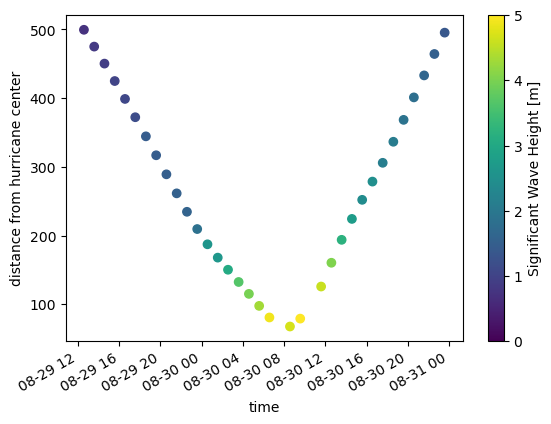

In [175]:
x = microswift_df.index
y = microswift_df.storm_distance
c = microswift_df['significant_height']

cmap = 'viridis'
norm = plt.Normalize(0, 5)  # min, max

fig, ax = plt.subplots()
sc = ax.scatter(x,y,c=c,norm=norm, cmap=cmap)
ax.set_xlabel('time')
ax.set_ylabel('distance from hurricane center')
fig.autofmt_xdate()

fig.colorbar(sc, ax=ax, label='Significant Wave Height [m]')

plt.show()

In [176]:
#unfinished, figure out how to make it proportional to hurricane direction


#figuring out storm direction

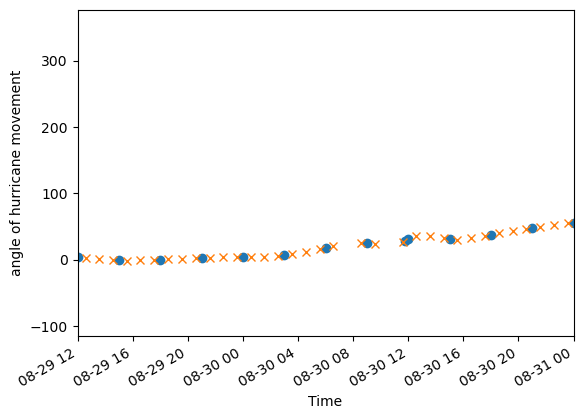

In [177]:


y = np.unwrap(pd.to_numeric(ibtracs_df.STORM_DIR), period=360)
x = ibtracs_df.index


interp_func = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")

xnew = microswift_df.index
ynew = interp_func(pd.to_numeric(xnew))
microswift_df['storm_direction'] = ynew % 360
#ibtracs_df.index = interpolate.interp1d(pd.to_numeric(x), y, kind="cubic")
#x = microswift_df.index #correspond to the microswift times
#ibtracs_df.STORM_DIR = f(pd.to_numeric(xnew))   # use interpolation function returned by `interp1d`

fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.plot(xnew, ynew, 'x')
ax.set_xlabel('Time')
ax.set_ylabel('angle of hurricane movement')
# ax.set_ylim([24, 34])
ax.set_xlim([pd.Timestamp('2023-08-29 12:00Z'), pd.Timestamp('2023-08-31 00:00Z')])
fig.autofmt_xdate()
plt.show()




In [178]:
anglefromstormdir = (microswift_df['storm_bearing']-microswift_df['storm_direction'])%360
xstorm = np.sin(anglefromstormdir*np.pi/180)* microswift_df.storm_distance
ystorm = np.cos(anglefromstormdir*np.pi/180)* microswift_df.storm_distance
microswift_df['anglefromstormdir'] = anglefromstormdir
microswift_df['xstorm'] = xstorm
microswift_df['ystorm'] = ystorm

In [179]:
#peak direction and storm direction

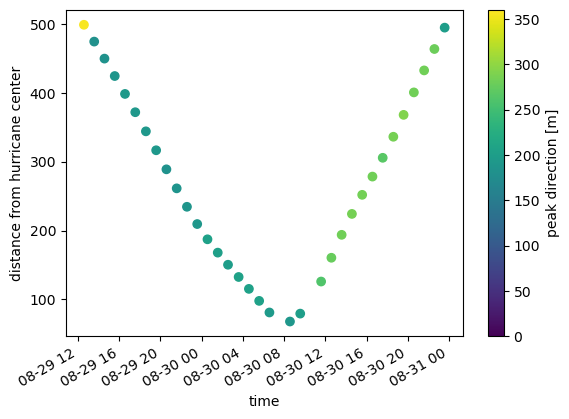

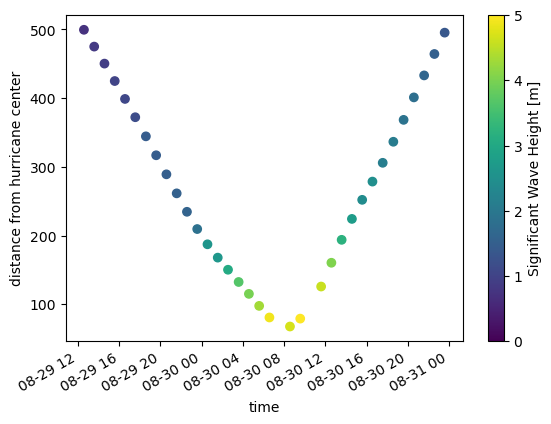

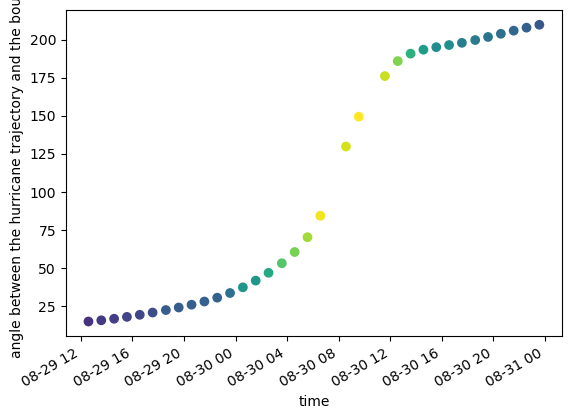

In [180]:


x = microswift_df.index
y = microswift_df.storm_distance
c = microswift_df['peak_direction']

cmap = 'viridis'
norm = plt.Normalize(0, 360)

fig, ax = plt.subplots()
sc = ax.scatter(x,y,c=c,norm=norm, cmap=cmap)
ax.set_xlabel('time')
ax.set_ylabel('distance from hurricane center')
fig.autofmt_xdate()

fig.colorbar(sc, ax=ax, label='peak direction [m]')

plt.show()

#radial distance again

x = microswift_df.index
y = microswift_df.storm_distance
c = microswift_df['significant_height']

cmap = 'viridis'
norm = plt.Normalize(0, 5)

fig, ax = plt.subplots()
sc = ax.scatter(x,y,c=c,norm=norm, cmap=cmap)
ax.set_xlabel('time')
ax.set_ylabel('distance from hurricane center')
fig.autofmt_xdate()

fig.colorbar(sc, ax=ax, label='Significant Wave Height [m]')

plt.show()

#radial distance but with angle from center

x = microswift_df.index
y = microswift_df['storm_bearing']

fig, ax = plt.subplots()
sc = ax.scatter(x,y,c=c,norm=norm)
ax.set_xlabel('time')
ax.set_ylabel('angle between the hurricane trajectory and the bouy')
fig.autofmt_xdate()


plt.show()

#plotting on coordinate plane

# angle microswift_df['bouytohurricaneangle'



In [181]:
microswift_df.info


<bound method DataFrame.info of                            significant_height  peak_period  peak_direction  \
datetime                                                                     
2023-08-29 12:35:12+00:00            0.709473     4.492188         356.500   
2023-08-29 13:34:56+00:00            0.841309     4.804688         180.500   
2023-08-29 14:34:40+00:00            0.905273     5.003906         182.875   
2023-08-29 15:34:24+00:00            1.002930     5.390625         187.500   
2023-08-29 16:34:08+00:00            1.060547     5.753906         193.250   
2023-08-29 17:33:52+00:00            1.155273     6.644531         191.250   
2023-08-29 18:35:44+00:00            1.460938     6.167969         192.125   
2023-08-29 19:35:28+00:00            1.446289     6.648438         192.125   
2023-08-29 20:35:12+00:00            1.491211     6.164062         183.000   
2023-08-29 21:34:56+00:00            1.537109     6.644531         186.625   
2023-08-29 22:34:40+00:00       

#graphing wave direction in x and y

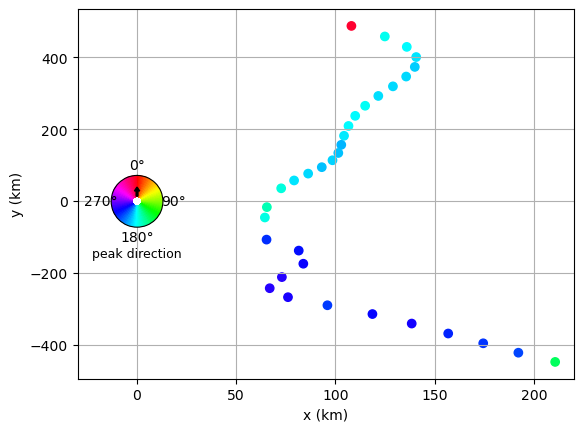

In [186]:
cmap = 'hsv'
norm = mpl.colors.Normalize(vmin=0, vmax=360)

fig, ax = plt.subplots()
x = microswift_df.xstorm
y = microswift_df.ystorm
c = (microswift_df['peak_direction']-microswift_df['storm_direction'])%360
sc = ax.scatter(x,y,c=c, cmap=cmap, norm=norm)
ax.set_xlim([-30, 220])
ax.set_xlabel('x (km)')

ax.set_ylabel('y (km)')

#circlebar


# cylic legend
legend_location = [0.05, 0.41,0.14, 0.14]  # x, y, width, height
ax2 = ax.inset_axes(legend_location, projection='polar')
azimuths = np.arange(0, 361, 1)
zeniths = np.linspace(0.2, 1, 10)
values = azimuths * np.ones((len(zeniths), len(azimuths)))
ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap=cmap, norm=norm)
ax2.set_yticks([])
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.xaxis.grid(False)
ax2.tick_params(pad=-3,labelsize=10)
ax2.set_ylim([0, 1])
ax2.set_xticks([0, np.pi/2, np.pi])
ax2.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])

ax3 = ax.inset_axes(legend_location)
ax2.set_xlabel('peak direction', fontsize=9, labelpad=2)



arrow_kwargs = dict(  #TODO: used for RMW norm
    dx=0,
    dy=0.2,
    width=0.05,
    color='k',
    lw=1,
    head_length=0.15,
)
ax3.arrow(0, 0.2, **arrow_kwargs)
ax3.set_axis_off()
ax3.set_ylim([-1, 1])
ax3.set_xlim([-1, 1])


# Add a color bar
##sc = plt.scatter(df['A'], df['B'], s=0, c=c1, cmap='jet', facecolors='none')
#cbar = plt.colorbar(sc)
#cbar.set_label('C', rotation=270, labelpad=10)

plt.grid()


plt.show()

The legend is centered on the hurricanes center, with an arrow indicating its direction of motion. The color of each dot indicates the peak direction. From this we can see that the peak direction is less aligned with the wind on the right front quadrant

#graphing height in x and y

In [191]:
cmap = 'hsv'
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
fig.tight_layout()

# first plot
x = microswift_df.xstorm
y = microswift_df.ystorm
c=microswift_df.significant_height
norm = plt.Normalize(0,6)
sc = ax[0,0].scatter(x,y,c=c, cmap=cmap, norm=norm)
ax[0,0].set_xlim([-20, 220])
ax[0,0].set_xlabel('x (km)')
ax[0,0].set_ylabel('y (km)')
# Add a color bar

fig.colorbar(sc, ax=ax[0,0], label='Significant Wave Height [m]')


#colorbar shows radial distance


cmap = 'inferno'
plt.grid()
x = microswift_df.xstorm
y = microswift_df.ystorm
c=microswift_df.storm_distance
norm = plt.Normalize(0,500)
sc = ax[0,1].scatter(x,y,c=c, cmap=cmap, norm=norm)
ax[0,1].set_xlim([-20, 220])
ax[0,1].set_xlabel('x (km)')

#ax[0,1].set_ylabel('y (km)')

fig.colorbar(sc, ax=ax[0,1], label='radial distance [km]')

plt.grid()



#radial distance again
cmap = 'inferno'
x = microswift_df.index
y = microswift_df.storm_distance
c = microswift_df['significant_height']

norm = plt.Normalize(0, 5)

sc = ax[1,0].scatter(x,y,c=c,norm=norm, cmap=cmap)
ax[1,0].set_xlabel('time')
ax[1,0].set_ylabel('distance from hurricane center')
fig.autofmt_xdate()

fig.colorbar(sc, ax=ax[1,0], label='Significant Wave Height [m]')
plt.grid()
plt.show()
fig.tight_layout()

SyntaxError: invalid syntax (2482357509.py, line 14)

sig wave height is smaller, closer to the eye,  in front right quadrant than in the back right quadrant?

#downloading data

In [184]:
drifter_df

latitude  longitude  \
id          time                                              
029         2023-08-28 21:34:56+00:00  27.624407 -82.959137   
            2023-08-28 22:34:40+00:00  27.631481 -82.962463   
            2023-08-28 23:34:24+00:00  27.640909 -82.964523   
            2023-08-29 00:34:08+00:00  27.649773 -82.964897   
            2023-08-29 01:33:52+00:00  27.657639 -82.963287   
...                                          ...        ...   
SPOT-30164D 2023-08-31 18:17:31+00:00  29.000870 -85.254470   
            2023-08-31 20:18:24+00:00  29.016930 -85.285870   
            2023-08-31 21:18:24+00:00  29.025770 -85.304230   
            2023-08-31 22:18:24+00:00  29.035670 -85.322050   
            2023-08-31 23:18:24+00:00  29.045480 -85.337620   

                                       significant_height  peak_period  \
id          time                                                         
029         2023-08-28 21:34:56+00:00            0.466788     3.779297   
            2023-08-28 22:34:40+00:00            0.511544     3.818359   
            2023-08-28 23:34:24+00:00            0.636357     4.058594   
            2023-08-29 00:34:08+00:00            0.627217     4.031250   
            2023-08-29 01:33:52+00:00            0.690253     4.175781   
...                                                   ...          ...   
SPOT-30164D 2023-08-31 18:17:31+00:00            0.945000     7.314000   
            2023-08-31 20:18:24+00:00            0.863000     7.314000   
            2023-08-31 21:18:24+00:00            0.847000     7.314000   
            2023-08-31 22:18:24+00:00            0.789000     7.314000   
            2023-08-31 23:18:24+00:00            0.832000     7.314000   

                                       peak_direction  \
id          time                                        
029         2023-08-28 21:34:56+00:00      164.438490   
            2023-08-28 22:34:40+00:00      163.872424   
            2023-08-28 23:34:24+00:00      156.447736   
            2023-08-29 00:34:08+00:00      157.328656   
            2023-08-29 01:33:52+00:00      157.724102   
...                                               ...   
SPOT-30164D 2023-08-31 18:17:31+00:00      168.399000   
            2023-08-31 20:18:24+00:00      169.856000   
            2023-08-31 21:18:24+00:00      172.286000   
            2023-08-31 22:18:24+00:00      170.548000   
            2023-08-31 23:18:24+00:00      170.548000   

                                       peak_directional_spread  mean_period  \
id          time                                                              
029         2023-08-28 21:34:56+00:00                34.371645     5.060513   
            2023-08-28 22:34:40+00:00                29.881568     5.014595   
            2023-08-28 23:34:24+00:00                31.289802     5.270532   
            2023-08-29 00:34:08+00:00                30.731675     5.408723   
            2023-08-29 01:33:52+00:00                26.012632     5.643678   
...                                                        ...          ...   
SPOT-30164D 2023-08-31 18:17:31+00:00                19.342130     5.920365   
            2023-08-31 20:18:24+00:00                21.057402     5.607473   
            2023-08-31 21:18:24+00:00                21.100202     5.520342   
            2023-08-31 22:18:24+00:00                22.543618     5.338056   
            2023-08-31 23:18:24+00:00                20.739607     5.216048   

                                       mean_direction  \
id          time                                        
029         2023-08-28 21:34:56+00:00      169.504317   
            2023-08-28 22:34:40+00:00      168.860478   
            2023-08-28 23:34:24+00:00      162.712107   
            2023-08-29 00:34:08+00:00      170.766392   
            2023-08-29 01:33:52+00:00      165.344909   
...                                               ...   
SPOT-30164D 2023-08-31 18:17:31

In [185]:
drifterids = drifter_df.index.get_level_values(level="id").unique()
print(drifterids)

Index(['029', '037', '046', '048', '300534060649690', '300534060941280',
       '300534060949490', '300534061518010', '300534061518160',
       '300534064703160', '300534064703730', '300534064800060',
       '300534064800070', '300534064800090', '300534064800250', 'SPOT-30025D',
       'SPOT-30052D', 'SPOT-30055D', 'SPOT-30061D', 'SPOT-30066D',
       'SPOT-30095D', 'SPOT-30101D', 'SPOT-30102D', 'SPOT-30103D',
       'SPOT-30164D'],
      dtype='object', name='id')
